In [1]:
import glob 
import tables
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
T='../results/08yr'
catalog_columns = ['f','colatitude','longitude','amplitude','inclination','polarization','phase','fdot','fddot','sigma_df/f','sigma_colatitude','sigma_longitude','sigma_dA/A','sigma_inclination','sigma_polarization','sigma_phase','sigma_dfdot/fdot','sigma_dfddot/fddot','sigma_Omega','SNR'] 
catalog = pd.read_table(T+"/SigmasAE.dat",delimiter=" ", header=None,index_col=False,names=catalog_columns)
catalog.head()

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,sigma_colatitude,sigma_longitude,sigma_dA/A,sigma_inclination,sigma_polarization,sigma_phase,sigma_dfdot/fdot,sigma_dfddot/fddot,sigma_Omega,SNR
0,0.000167,0.954373,3.954100,1.161330e-21,0.584423,2.811940,4.50278,3.934090e-21,3.402775e-37,1.146358e-09,0.140294,0.167172,1.389535,2.298213,4.038658,8.090218,2319.0080,-2.038056e+35,387.10050,7.325647
1,0.000212,1.514540,0.837797,1.367850e-21,2.893390,0.106658,4.17682,1.681630e-20,4.891866e-36,5.236547e-10,0.063329,0.059293,3.850107,15.411990,62.699350,125.403700,241.8305,-2.589325e+45,77.28670,16.531061
2,0.000219,0.753700,0.679597,1.248440e-21,0.944777,0.057978,4.82894,1.418480e-20,3.361257e-36,9.178591e-10,0.098533,0.138354,0.321197,0.303171,0.382849,0.809264,489.7364,-4.787731e+55,187.96540,9.833322
3,0.000227,2.555120,2.771070,2.011320e-21,1.401630,0.017058,4.35799,7.452880e-21,8.971106e-37,8.849340e-10,0.090307,0.156249,0.113719,0.060726,0.136491,0.310786,917.8140,-3.316872e+66,160.32200,9.992462
4,0.000228,2.314790,5.137680,2.022570e-21,2.573180,0.387113,5.68457,2.339130e-20,8.783644e-36,3.864640e-10,0.042253,0.054793,0.461761,0.787383,1.465059,2.931015,122.3382,-2.346923e+76,34.10879,23.505228


In [3]:
def ecliptic_to_galactic(row):

    ecl_lon = row[2]*u.rad
    ecl_lat = (np.pi/2 - row[1])*u.rad

    gal = SkyCoord(ecl_lon,ecl_lat,frame='barycentrictrueecliptic').galactic
    
    gal_lon = gal.l.degree
    gal_lat = gal.b.degree
    
    return pd.Series(dict(l=gal_lon,b=gal_lat))



#catalog['b']=catalog.apply(lambda row: SkyCoord(catalog.longitude*u.rad,(np.pi/2 - catalog.colatitude)*u.rad,frame='barycentrictrueecliptic').galactic.b.degree, axis=1)
catalog =  catalog.join(catalog.apply(lambda row: ecliptic_to_galactic(row), axis=1))

In [4]:
TSUN = 4.9169e-6
PC = 3.0856775807e16
CLIGHT = 299792458.

def amp_to_distance(row):
    
    f = row[0]
    A = row[3]
    fdot = row[7]

    Mc = 0
    DL = 0
    if(fdot>0):
        Mc = (( fdot * (5./96.) / np.pi**(8./3.) / f**(11./3.))**(3./5.))/TSUN
        DL = ((5./48.)*(fdot/(np.pi**2*f**3*A))*CLIGHT/PC)
    
    return pd.Series(dict(mchirp=Mc,distance=DL))

    
catalog =  catalog.join(catalog.apply(lambda row: amp_to_distance(row), axis=1))
catalog.head()

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,...,sigma_polarization,sigma_phase,sigma_dfdot/fdot,sigma_dfddot/fddot,sigma_Omega,SNR,l,b,mchirp,distance
0,0.000167,0.954373,3.954100,1.161330e-21,0.584423,2.811940,4.50278,3.934090e-21,3.402775e-37,1.146358e-09,...,4.038658,8.090218,2319.0080,-2.038056e+35,387.10050,7.325647,26.979350,50.753900,0.647315,74.887180
1,0.000212,1.514540,0.837797,1.367850e-21,2.893390,0.106658,4.17682,1.681630e-20,4.891866e-36,5.236547e-10,...,62.699350,125.403700,241.8305,-2.589325e+45,77.28670,16.531061,159.194534,-33.496950,0.913186,132.378587
2,0.000219,0.753700,0.679597,1.248440e-21,0.944777,0.057978,4.82894,1.418480e-20,3.361257e-36,9.178591e-10,...,0.382849,0.809264,489.7364,-4.787731e+55,187.96540,9.833322,121.980912,-5.709033,0.763601,110.180909
3,0.000227,2.555120,2.771070,2.011320e-21,1.401630,0.017058,4.35799,7.452880e-21,8.971106e-37,8.849340e-10,...,0.136491,0.310786,917.8140,-3.316872e+66,160.32200,9.992462,264.805670,1.918278,0.481860,32.472901
4,0.000228,2.314790,5.137680,2.022570e-21,2.573180,0.387113,5.68457,2.339130e-20,8.783644e-36,3.864640e-10,...,1.465059,2.931015,122.3382,-2.346923e+76,34.10879,23.505228,333.292859,-36.862214,0.944428,99.525353


,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,...,sigma_polarization,sigma_phase,sigma_dfdot/fdot,sigma_dfddot/fddot,sigma_Omega,SNR,l,b,mchirp,distance
17644,0.005410,1.99230,4.520240,5.278370e-23,1.56775,0.182346,5.04580,2.732560e-16,5.060935e-29,1.107411e-10,...,0.005869,0.039077,0.003044,-inf,0.062172,81.662927,340.127489,-2.978137,0.246510,3352.963296
18124,0.005877,2.40011,4.091510,4.693420e-23,1.58429,0.253199,5.82024,7.557710e-16,3.563787e-28,1.247769e-10,...,0.006926,0.044561,0.001244,-inf,0.041112,72.546620,309.707106,-1.465078,0.378280,8135.410416
18309,0.006132,1.97145,4.455950,4.417050e-23,1.57060,1.359730,2.73407,1.357210e-15,1.101530e-27,1.266301e-10,...,0.006747,0.044670,0.000700,-inf,0.066805,71.213006,339.337950,0.515407,0.489580,13668.027848
18644,0.006728,1.95578,4.374560,4.861780e-23,1.56798,0.235336,0.69306,5.161680e-16,1.452025e-28,1.119133e-10,...,0.006028,0.039097,0.001642,-inf,0.044967,80.088664,337.680915,4.592751,0.223474,3574.838038
18714,0.006877,1.36839,0.906438,1.974190e-22,1.58109,2.657470,5.63246,4.262560e-16,9.686979e-29,2.559428e-11,...,0.001510,0.008711,0.000464,-inf,0.003986,341.757602,154.757455,-25.107462,0.189827,680.625870


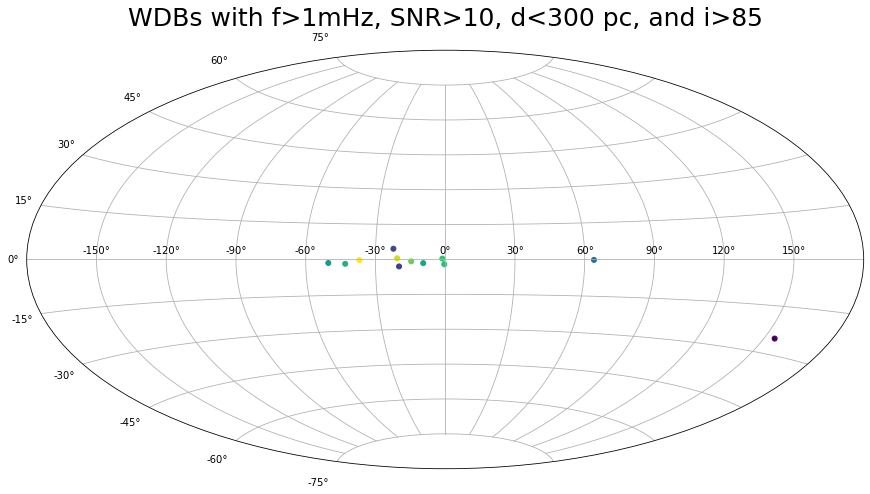

In [5]:
f = plt.figure(figsize=(15,15))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.title('WDBs with f>1mHz, SNR>10, d<300 pc, and i>85',size=25,pad=25)

# > 5 mHz GW frequency
f_min = 0.005
f_max = 1

# > 89 degrees inclination
i_min = np.radians(89)
i_max = np.radians(91)

# > 10 SNR
SNR_min = 10
SNR_max = 1e6

# < 0.1 sq deg
so_min = 0.0001
so_max = 0.1

cut = catalog['f'].between(f_min,f_max) \
    & catalog['inclination'].between(i_min,i_max) \
    & catalog['SNR'].between(SNR_min,SNR_max) \
    & catalog['sigma_Omega'].between(so_min,so_max)

gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=25,c=catalog[cut]['distance'])
catalog[cut].head()

In [6]:
# Make GBMCMC input file and apply desired cuts
output_columns = ['f','fdot','colatitude','longitude','amplitude','inclination','polarization','phase']
output = pd.DataFrame(columns = output_columns)
output['f'] = catalog[cut]['f']
output['fdot'] = catalog[cut]['fdot']
output['colatitude'] = catalog[cut]['colatitude']
output['longitude'] = catalog[cut]['longitude']
output['amplitude'] = catalog[cut]['amplitude']
output['inclination'] = catalog[cut]['inclination']
output['polarization'] = catalog[cut]['polarization']
output['phase'] = catalog[cut]['phase']
output = output.astype('float32')
decimals = pd.Series([8,23,5,5,27,5,5,5], index=output_columns)
output = output.round(decimals)
output.to_csv(T+"/Binary_Parameters.dat",sep=' ',header=None,index=False)